deVaucoulours
0.007053
29096.0048691


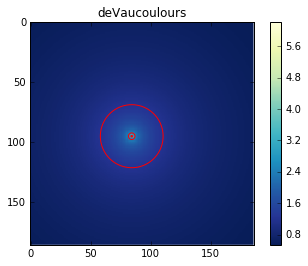

In [7]:
% matplotlib inline
import numpy as np
import pylab as plt
import psf
import time

def deVacoulours((x,y), x0, y0, F, r0, q = 1.0, posang=0.0):
    spa = np.sin(posang / 180.0 * np.pi)
    cpa = np.cos(posang / 180.0 * np.pi)

    # Define xprime coordinates in the rotated frame for convenience
    # This uses a standard rotation matrix
    xp = (x - x0) * cpa - (y - y0) * spa
    yp = (x - x0) * spa + (y - y0) * cpa
    # Defined r^2 (no need to take a square root)
    r = np.sqrt(xp * xp / q / q + yp * yp)
    return F/0.010584/r0**2*np.exp(-(r/r0)**(0.25))
    
res_fac = 3
pad_fac = 2
x=np.arange(0.,31*res_fac*pad_fac)
y=np.arange(0.,31*res_fac*pad_fac)
xg, yg = np.mgrid[:len(x), :len(x)]
#img=np.sqrt(xg**2+yg**2)
F=1.
r0=1.5 / 0.385
PA = 174.8
el = 0.09
q = 1./np.sqrt(1.-el**2)
print 'deVaucoulours'
start = time.clock()
img = deVacoulours((xg,yg), (len(x)-1)/2+3,(len(x)-1)/2-8,F,r0, q=q, posang=174.8)
print time.clock()-start

print np.sum(img)
levels =  np.arange(0.2,1.1,0.2)*np.max(img)

plt.figure()
plt.title('deVaucoulours')
plt.contour(img, levels, colors='r', widths=0.1)
plt.imshow(img, interpolation='none', cmap='YlGnBu_r')
plt.colorbar()


Moffat PSF
0.010506
1.0


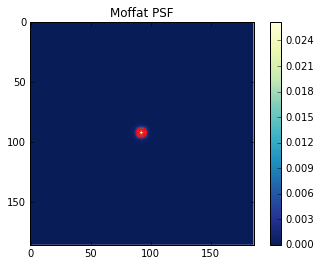

In [8]:
xo=0.
yo=0.
alpha=1./0.385*res_fac
beta=2.0*res_fac
nx=len(x)
ny=len(y)
print 'Moffat PSF'
start = time.clock()
#PSF_model = psf.moffat_kernel(xo, yo, alpha, beta, nx=len(x), ny=len(y)) # this one is slower as it includes sub-pixel integration
PSF_model = psf.moffat(xg, yg, (len(x)-1)/2,  (len(y)-1)/2, alpha, beta, q = 1.0, posang = 0.0) # fast
PSF_model /= np.sum(PSF_model)
print time.clock()-start
#PSF_model += psf.moffat_kernel(xo+20., yo, alpha, beta, nx=len(x), ny=len(y))
levels =  np.arange(0.2,1.1,0.2)*np.max(PSF_model)
print np.sum(PSF_model)
plt.figure()
plt.title('Moffat PSF')
plt.contour(PSF_model, levels, colors='r', widths=0.1)
plt.imshow(PSF_model, interpolation='none', cmap='YlGnBu_r')
plt.colorbar()


Scipy Convolution
3.603651
29130.4001569
FFT Convolution


NameError: name 'fac' is not defined

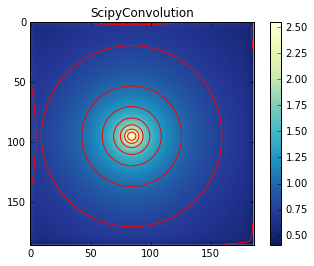

In [9]:
from scipy.signal import convolve2d

# NOTE: YOU WANT A ZERO PADDED deVacouleours CONVOLVED WITH A FULL SIZE MOFFAT!

#MAYBE BEST TO SEE WHY GALSIM IS SOOO MUCH SLOWER....
print 'Scipy Convolution'
start = time.clock()

conv = convolve2d(PSF_model,img, boundary='symm', mode='same')
print time.clock()-start
print np.sum(conv)

plt.figure()
plt.title('ScipyConvolution')
levels =  np.arange(0.2,1.2,0.1)*np.max(conv)
plt.contour(conv, levels, colors='r', widths=0.1)
plt.imshow(conv, interpolation='none', cmap='YlGnBu_r')
plt.colorbar()


start = time.clock()
print 'FFT Convolution'
N=len(PSF_model)
#zp1 = np.lib.pad(PSF_model,(len(PSF_model),len(PSF_model)),'constant')
x2=np.arange(0.,2*31*fac-1)
y2=np.arange(0.,2*31*fac-1)
xg2, yg2 = np.mgrid[:len(x2), :len(x2)]

zp1 = np.lib.pad(PSF_model,(len(PSF_model)/2,len(PSF_model)/2),'constant')
zp2 = np.lib.pad(img,(len(img)/2,len(img)/2),'constant')
zconv = np.fft.irfft2(np.fft.rfft2(zp1) * np.fft.rfft2(zp2))
zconv = np.fft.fftshift(zconv)
print time.clock()-start

print zp1.shape, zp2.shape, PSF_model.shape
plt.figure()
plt.title('FFT padded')
levels =  np.arange(0.2,1.2,0.1)*np.max(zconv)
plt.contour(zconv, levels, colors='r', widths=0.1)
plt.imshow(zconv, interpolation='none', cmap='YlGnBu_r')
plt.colorbar()

#zp2 = np.zeros((2*len(img),2*len(img)) )
#zp1[len(PSF_model):len(PSF_model)]+=PSF_model
#zp2[len(img):len(img)]+=img


#conv = np.fft.irfft2(np.fft.rfft2(zp1) * np.fft.rfft2(zp2))
print 'FFT Convolution'
start = time.clock()
conv = np.fft.irfft2(np.fft.rfft2(PSF_model) * np.fft.rfft2(img))
conv = np.fft.fftshift(conv)
print time.clock()-start
print np.sum(conv)

plt.figure()
plt.title('FFT Convolution')
levels =  np.arange(0.2,1.2,0.1)*np.max(conv)
plt.contour(conv, levels, colors='r', widths=0.1)
plt.imshow(conv, interpolation='none', cmap='YlGnBu_r')
plt.colorbar()

alpha 7.79220779221
conv.shape (186, 186)
trm.shape (94, 94)
trm peak (46, 46)
31 3 93
subkern.shape (91, 91)
subkern.shape (94, 94)


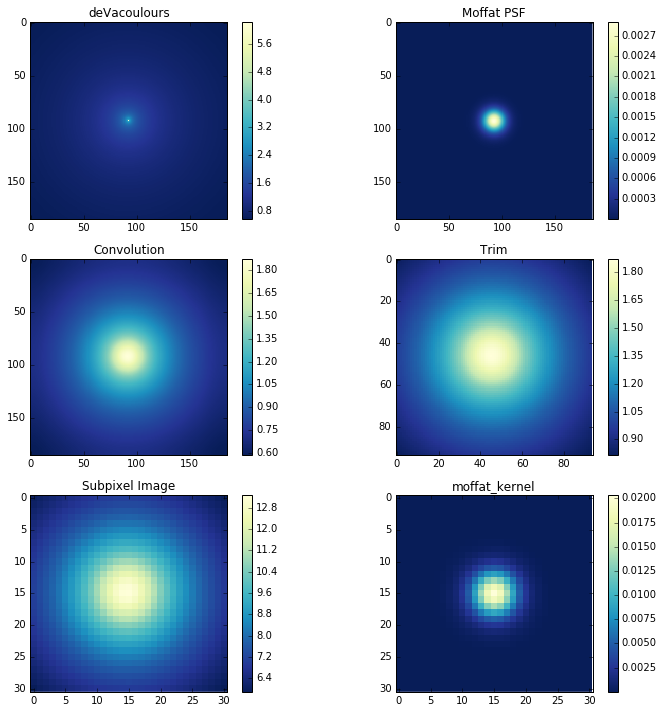

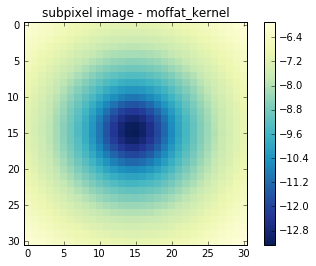

In [127]:
% matplotlib inline
import numpy as np
import pylab as plt
import psf
import integrate
integrate = integrate.integrate()

def deVaucolours_model(x0, y0, F, r0, moffat_alpha, moffat_beta, q = 1.0, posang=0.0, npx=31):
    # 1. Sub-pixelized and padded model of deVacoulours profile and moffat.
    # 2. Convolve the profiles
    # 3. Trim the boundaries.
    # 4. Sub-pixel integration
    # 5. Return output
    # 1. Sub-pixelized and padded model of deVacoulours profile and moffat.
    subpixel_padding = 3
    boundary_padding = 2
    #npx_p_sp = (npx * subpixel_padding - subpixel_padding + 1)*boundary_padding
    npx_p_sp = (npx)*subpixel_padding*boundary_padding
    x=np.arange(0.,npx_p_sp)
    y=np.arange(0.,npx_p_sp)
    xg, yg = np.mgrid[:len(x), :len(x)]
    img = deVacoulours((xg,yg), (len(x)-1)/2,(len(y)-1)/2,F,r0, q=q, posang=posang)

    print 'alpha', alpha
    PSF_model = psf.moffat(xg, yg, (len(x)-1)/2+0.5,  (len(y)-1)/2+0.5, alpha*subpixel_padding, beta, q = 1.0, posang = 0.0) # fast
    #PSF_model /= np.sum(PSF_model)
    #normfactor = (beta - 1.0) / (np.pi * alpha * subpixel_padding * alpha * subpixel_padding)
    #PSF_model /= normfactor

    # 2. Convolve the profiles
    conv = np.fft.irfft2(np.fft.rfft2(PSF_model) * np.fft.rfft2(img))
    conv = np.fft.fftshift(conv)

    #conv=  PSF_model.copy() # THIS LINE IS FOR TESTING. REMOVE FROM CODE!!!

    # 3. Trim the boundaries.
    trm = conv[(npx_p_sp-1)/4:-(npx_p_sp-1)/4+1, (npx_p_sp-1)/4:-(npx_p_sp-1)/4+1]
    #trm = conv[(npx_p_sp-1)/4-1:-(npx_p_sp-1)/4, (npx_p_sp-1)/4-1:-(npx_p_sp-1)/4]
    print 'conv.shape',conv.shape
    print 'trm.shape',trm.shape
    print 'trm peak', np.unravel_index(trm.argmax(), trm.shape)

    
    # 4. Sub-pixel integration
    
    # I think this requires nx and ny to be odd
    # That is something to fix in the long run
    #fwhm = alpha * 2.0 * (2.0 ** (1.0 / beta) - 1.0) ** 0.5
    subsamp=subpixel_padding
    # The slow, but more understandable way
    # Loop over pixels
    # for j, y in enumerate(range(-nx / 2 + 1, nx/2 + 1)):
        # for i, x in enumerate(range(-nx / 2 + 1, nx/2 + 1)):
            # Do the double integral for each pixel
            # The center of the middle pixel is 0, 0
            # Note everything is y, x
    # kern[j, i] = dblint(x0, x - 0.5, x + 0.5, y0, y - 0.5, y + 0.5, alpha, beta, q=q, posang=posang)
    # Subsample the moffat array
    # Say we have 11 pixels in each direction, then 0, 0 is at array index 5, 5
    # If we subsample that by a factor of 10, we want 101 x 101 pixels
    subkern = np.zeros((npx * subsamp - subsamp + 1, npx * subsamp - subsamp + 1 ))
    x2 = np.linspace(-npx / 2  + 0.5, npx / 2 + 0.5, npx * subsamp + 1  )
    y2 = np.linspace(-npx / 2  + 0.5, npx / 2 + 0.5, npx * subsamp + 1  )
    x2d, y2d = np.meshgrid(x2, y2)
    print npx, subsamp, npx*subsamp
    #subkern = moffat(x2d, y2d, x0, y0, alpha, beta) # cut out Moffat ellipticity and rotation options
    # THIS SHOULD BE 91
    print 'subkern.shape', subkern.shape
    subkern=trm.copy()
    # THIS SHOULD BE 94
    print 'subkern.shape', subkern.shape
    result4d = np.zeros((npx, npx, subsamp + 1, subsamp + 1))
    #print 'subkern.shape, npx, subsamp', subkern.shape, npx, subsamp
    #print 'result4d.shape', result4d.shape
    #result4d[:, :, :-1, :-1] = d[:-1, :-1].reshape((npx, subsamp, npx, subsamp)).swapaxes(1, 2)
    kern4d = integrate.make4d(subkern, npx, npx, subsamp)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    spx = integrate.simp4d(kern4d, dx, dy)

    
    plt.figure(1, figsize=(12,12))
    plt.subplot(321)
    plt.imshow(img, interpolation = 'none', cmap='YlGnBu_r')
    plt.colorbar()
    plt.title('deVacoulours')
    plt.subplot(322)
    plt.imshow(PSF_model, interpolation = 'none', cmap='YlGnBu_r')
    plt.title('Moffat PSF')
    plt.colorbar()
    plt.subplot(323)
    plt.imshow(conv, interpolation = 'none', cmap='YlGnBu_r')
    plt.colorbar()
    plt.title('Convolution')
    plt.subplot(324)
    plt.imshow(trm, interpolation = 'none', cmap='YlGnBu_r')
    plt.title('Trim')
    plt.colorbar()
    plt.subplot(325)
    plt.imshow(spx, interpolation = 'none', cmap='YlGnBu_r')
    plt.title('Subpixel Image')
    plt.colorbar()
    
    mft = psf.moffat_kernel(x0, y0, alpha, beta, nx=31, ny=31)
    
    plt.subplot(326)
    plt.imshow(mft, interpolation = 'none', cmap='YlGnBu_r')
    plt.title('moffat_kernel')
    plt.colorbar()
    
    plt.figure()
    plt.imshow(mft-spx, interpolation='none', cmap='YlGnBu_r')
    #plt.title('moffat_kernal - subpixel image')
    #plt.imshow(spx-mft, interpolation='none', cmap='YlGnBu_r')
    plt.title('subpixel image - moffat_kernel')
    plt.colorbar()
    
F=1.
r0=1.5 / 0.385
PA = 174.8
el = 0.09
q = 1./np.sqrt(1.-el**2)
moffat_alpha = 1.6
moffat_beta = 2.0
x0 = 0.
y0 = 0.

deVaucolours_model(x0, y0, F, r0, moffat_alpha, moffat_beta, q = q, posang=PA, npx=31)